<a href="https://colab.research.google.com/github/davidleonardoouuu88/NuevoProyectoIA/blob/main/FINAL%20ULTRACOMPRIMIDO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", palette="muted")


In [42]:
BASE = "/content/drive/MyDrive/datasets/IA/NuevoProyectoIA/database2"

FILE_CARAC = f"{BASE}/Características generales, seguridad social en salud y educación.CSV"
FILE_FT    = f"{BASE}/Fuerza de trabajo.CSV"
FILE_HOGAR = f"{BASE}/Datos del hogar y la vivienda.CSV"
FILE_OCUP  = f"{BASE}/Ocupados.CSV"

READ = dict(sep=";", encoding="latin-1", low_memory=False)

In [43]:
df_carac = pd.read_csv(FILE_CARAC, **READ)
df_ft    = pd.read_csv(FILE_FT, **READ)
df_hogar = pd.read_csv(FILE_HOGAR, **READ)
df_ocup  = pd.read_csv(FILE_OCUP, **READ)

for df in [df_carac, df_ft, df_hogar, df_ocup]:
    df.columns = df.columns.str.strip()

In [44]:
KEYS = ["DIRECTORIO", "SECUENCIA_P", "ORDEN"]

for df in [df_carac, df_ft, df_hogar, df_ocup]:
    for k in KEYS:
        if k in df.columns:
            df[k] = df[k].astype(str)


In [45]:
KEYS = ["DIRECTORIO", "SECUENCIA_P", "ORDEN"]

for df in [df_carac, df_ft, df_hogar, df_ocup]:
    for k in KEYS:
        if k in df.columns:
            df[k] = df[k].astype(str)


In [53]:
df = df_indiv.copy()
df = df.merge(df_ocup[['DIRECTORIO', 'SECUENCIA_P', 'ORDEN', 'P6920', 'P6940', 'P6800']], on=KEYS, how='left')

df["sexo"] = df["P4000"]
df["edad"] = df["P6040"]
df["edu"]  = df["P6070"]

In [57]:
df["salud_no"] = df["P6920"].apply(lambda x: True if x == 2 else False)
df["pen_no"]   = df["P6940"].apply(lambda x: True if (pd.isna(x) or x == 2) else False)

df["informal"] = np.where(df["salud_no"] & df["pen_no"], 1, 0)

In [64]:
def map_edu(x):
    if pd.isna(x): return np.nan
    if x <= 2: return "Primaria o menos"
    if x == 3: return "Secundaria"
    if x == 4: return "Media"
    if x == 5: return "Técnica"
    if x == 6: return "Universitaria"
    return "Otro"

df["edu_cat"] = df["edu"].apply(map_edu)

# Sexo
df["sexo_cat"] = df["sexo"].map({1:"Hombre", 2:"Mujer"}).fillna("Otro/NS")
df["informal_cat"] = df["informal"].map({0:"Formal",1:"Informal"})

In [58]:
if "informal" not in df.columns:
    raise ValueError("La columna 'informal' no existe en df. Revisa que sí hiciste el merge con Ocupados y creaste informal ahí.")

if "informal_cat" not in df.columns:
    df["informal_cat"] = df["informal"].map({0: "Formal", 1: "Informal"})

print(df[["informal", "informal_cat"]].head())
print(df["informal_cat"].value_counts(dropna=False))


   informal informal_cat
0         1     Informal
1         0       Formal
2         0       Formal
3         0       Formal
4         1     Informal
informal_cat
Formal      35680
Informal    16047
Name: count, dtype: int64


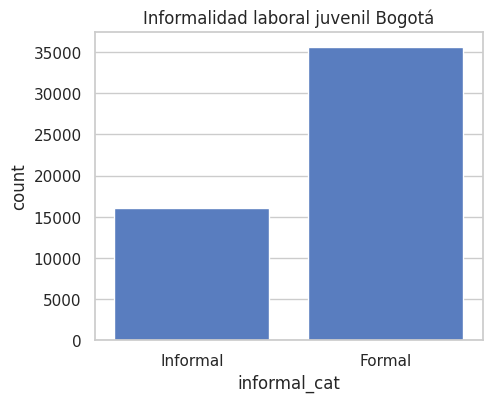

In [59]:
# 9.1 Informalidad total
plt.figure(figsize=(5,4))
sns.countplot(data=df, x="informal_cat")
plt.title("Informalidad laboral juvenil Bogotá")
plt.show()



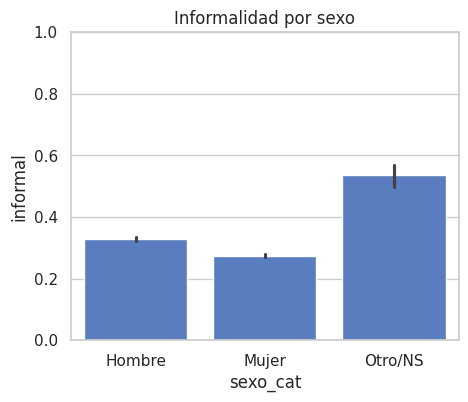

In [65]:
# 9.2 Informalidad por sexo
plt.figure(figsize=(5,4))
sns.barplot(data=df, x="sexo_cat", y="informal")
plt.title("Informalidad por sexo")
plt.ylim(0,1)
plt.show()



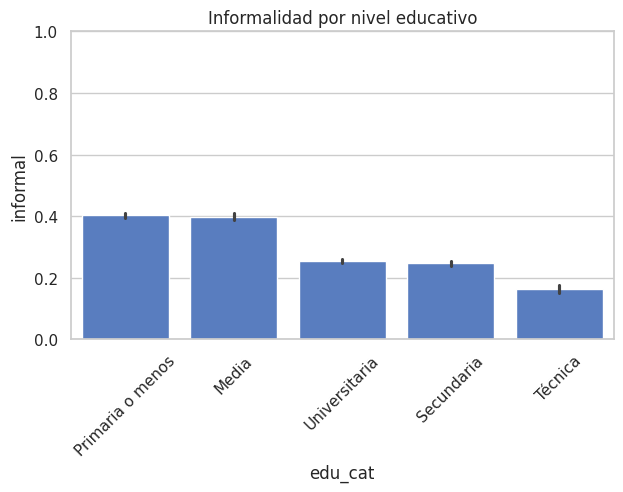

In [66]:
# 9.3 Informalidad por educación
plt.figure(figsize=(7,4))
order = df.groupby("edu_cat")["informal"].mean().sort_values(ascending=False).index
sns.barplot(data=df, x="edu_cat", y="informal", order=order)
plt.xticks(rotation=45)
plt.title("Informalidad por nivel educativo")
plt.ylim(0,1)
plt.show()



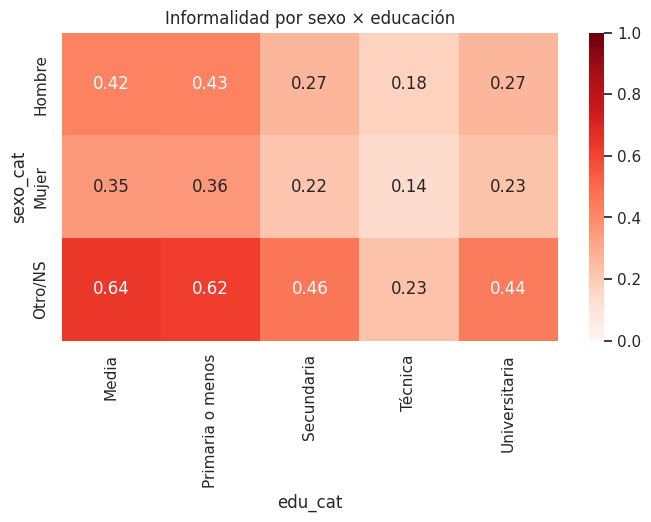

In [67]:
# 9.4 Heatmap sexo × educación
tabla = pd.crosstab(df["sexo_cat"], df["edu_cat"], values=df["informal"], aggfunc="mean")
plt.figure(figsize=(8,4))
sns.heatmap(tabla, annot=True, fmt=".2f", cmap="Reds", vmin=0, vmax=1)
plt.title("Informalidad por sexo × educación")
plt.show()



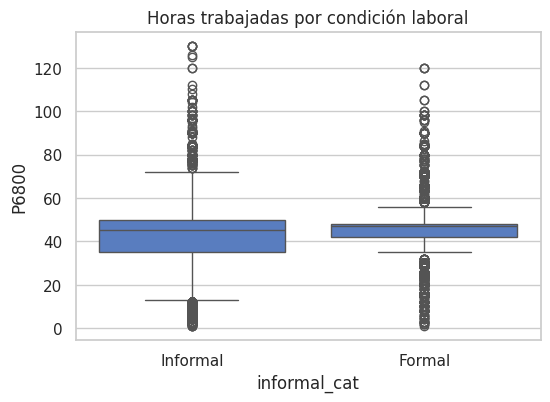

In [62]:
# 9.5 Boxplot horas vs informalidad
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="informal_cat", y="P6800")
plt.title("Horas trabajadas por condición laboral")
plt.show()

Aquí los dos modelos de IA que decidí asumir


In [68]:
!pip install shap --quiet


In [69]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)

import shap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted")


In [70]:
assert "informal" in df.columns, "No encuentro la columna 'informal' en df."

cat_features = ["sexo_cat", "edu_cat"]
num_features = ["edad", "P6800"]
df_ml = df.copy()
df_ml = df_ml.dropna(subset=cat_features + num_features + ["informal"])

X = df_ml[cat_features + num_features]
y = df_ml["informal"].astype(int)

print("Shape para modelos:", X.shape)
print("Proporción de informalidad:", y.mean().round(3))


Shape para modelos: (28154, 4)
Proporción de informalidad: 0.57


In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (19707, 4) Test: (8447, 4)


In [72]:
# Transformador para categóricas y numéricas
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_features),
        ("num", StandardScaler(), num_features),
    ],
    remainder="drop"
)


In [73]:
# Pipeline de Regresión Logística
log_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=500, solver="lbfgs"))
])

log_clf.fit(X_train, y_train)

# Predicciones
y_pred_log = log_clf.predict(X_test)
y_prob_log = log_clf.predict_proba(X_test)[:, 1]

# Métricas
acc_log = accuracy_score(y_test, y_pred_log)
auc_log = roc_auc_score(y_test, y_prob_log)

print("=== Regresión Logística ===")
print("Accuracy:", round(acc_log, 3))
print("ROC-AUC:", round(auc_log, 3))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred_log))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_log, digits=3))


=== Regresión Logística ===
Accuracy: 0.62
ROC-AUC: 0.656

Matriz de confusión:
[[1560 2072]
 [1141 3674]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.578     0.430     0.493      3632
           1      0.639     0.763     0.696      4815

    accuracy                          0.620      8447
   macro avg      0.608     0.596     0.594      8447
weighted avg      0.613     0.620     0.608      8447



In [74]:
# Pipeline de Random Forest
rf_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]

# Métricas
acc_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

print("=== Random Forest ===")
print("Accuracy:", round(acc_rf, 3))
print("ROC-AUC:", round(auc_rf, 3))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_rf, digits=3))


=== Random Forest ===
Accuracy: 0.68
ROC-AUC: 0.733

Matriz de confusión:
[[2312 1320]
 [1382 3433]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.626     0.637     0.631      3632
           1      0.722     0.713     0.718      4815

    accuracy                          0.680      8447
   macro avg      0.674     0.675     0.674      8447
weighted avg      0.681     0.680     0.680      8447



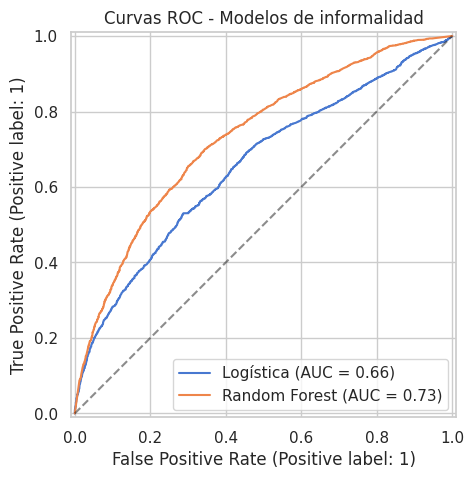

In [75]:
plt.figure(figsize=(6,5))

RocCurveDisplay.from_predictions(
    y_test, y_prob_log, name="Logística", ax=plt.gca()
)
RocCurveDisplay.from_predictions(
    y_test, y_prob_rf, name="Random Forest", ax=plt.gca()
)

plt.plot([0,1],[0,1],"k--", alpha=0.5)
plt.title("Curvas ROC - Modelos de informalidad")
plt.grid(True)
plt.show()


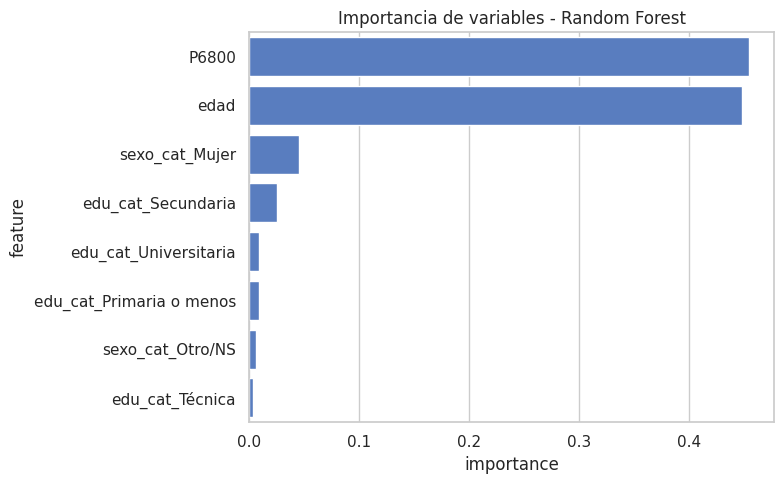

,feature,importance
7,P6800,0.454
6,edad,0.448
0,sexo_cat_Mujer,0.045
3,edu_cat_Secundaria,0.026
5,edu_cat_Universitaria,0.009
2,edu_cat_Primaria o menos,0.009
1,sexo_cat_Otro/NS,0.006
4,edu_cat_Técnica,0.003


In [76]:
rf_model = rf_clf.named_steps["model"]
ohe = rf_clf.named_steps["preprocess"].named_transformers_["cat"]
scaler = rf_clf.named_steps["preprocess"].named_transformers_["num"]
cat_feature_names = ohe.get_feature_names_out(cat_features)
num_feature_names = np.array(num_features)
feature_names = np.concatenate([cat_feature_names, num_feature_names])

importances = rf_model.feature_importances_

imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=imp_df.head(15), x="importance", y="feature")
plt.title("Importancia de variables - Random Forest")
plt.tight_layout()
plt.show()

imp_df.head(15)
